# Caledon Woods & I
    
Let's see how successful I am with Caledon Woods. I will attempt to draw insights on the following questions:

1. Can I map my general performace over the past two years?
2. What holes cause harship? And how consistent are these hardships?
3. What types of holes cause the harship?
4. How does putting, fairways, and greens impact your score?

In [179]:
from pymongo import MongoClient
from sys import path
path.append('../../../../')                     # Import the entire project.
from My_Golf_Journey.config import mongo_config
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [66]:
client = MongoClient(mongo_config['conn_str'])
db = client.Golf_Stats_DB
collection = db.Scorecards

## Question 1

At first, I want to map how my score has changed over the past two years. I have been grinding and I know I am better. Let's get the numbers to prove it!

I will attempt to break down this question into two categories.

1. Measure my general scoring average over the last two years. (Rolling Average)
2. Create ratios regarding the number of rounds I shot in different shot ranges.

In [67]:
caledon_rounds = list(collection.aggregate([
    {"$match": {"courseSnapshots.courseGlobalId": 17772}},
    {"$unwind": "$scorecardDetails"},
    {"$sort": {"scorecardDetails.scorecard.startTime" : 1}},
    {"$unwind": "$scorecardDetails.scorecard.holes"}, 
    {"$group": {"_id": "$scorecardDetails.scorecard.holes.number",
        "putting_average": {"$avg": "$scorecardDetails.scorecard.holes.putts"},
        "scoring_average": {"$avg": "$scorecardDetails.scorecard.holes.strokes"}}}   , 
    {'$sort': {"_id": 1}}
]))
print(len(caledon_rounds))
for round in caledon_rounds:
    print(round)

18
{'_id': 1, 'putting_average': 1.736, 'scoring_average': 4.64}
{'_id': 2, 'putting_average': 1.704, 'scoring_average': 4.248}
{'_id': 3, 'putting_average': 1.656, 'scoring_average': 3.456}
{'_id': 4, 'putting_average': 1.7741935483870968, 'scoring_average': 4.136}
{'_id': 5, 'putting_average': 1.888, 'scoring_average': 3.448}
{'_id': 6, 'putting_average': 1.6774193548387097, 'scoring_average': 4.524193548387097}
{'_id': 7, 'putting_average': 1.6290322580645162, 'scoring_average': 3.7903225806451615}
{'_id': 8, 'putting_average': 1.6612903225806452, 'scoring_average': 5.120967741935484}
{'_id': 9, 'putting_average': 1.7258064516129032, 'scoring_average': 4.290322580645161}
{'_id': 10, 'putting_average': 1.656, 'scoring_average': 5.208}
{'_id': 11, 'putting_average': 1.75, 'scoring_average': 3.2338709677419355}
{'_id': 12, 'putting_average': 1.7016129032258065, 'scoring_average': 5.112903225806452}
{'_id': 13, 'putting_average': 1.685483870967742, 'scoring_average': 3.1129032258064515}

In [98]:
caledon_rounds = list(collection.aggregate([
    {"$match": {"courseSnapshots.courseGlobalId": 17772,
                "scorecardDetails.scorecard.holesCompleted": 18.0
    }},
    {"$unwind": "$scorecardDetails"},
    {"$sort": {"scorecardDetails.scorecard.startTime" : 1}},
    {"$project": {"_id": 0, "scorecardDetails.scorecard.startTime": 1}}
]))
print(len(caledon_rounds))
dates = [caledon_rounds[i]['scorecardDetails']['scorecard']['startTime'] for i in range(0, len(caledon_rounds), 5)]
print(len(dates))

121
25


In [127]:
# Get all the score data overtime. The final format is {'Date': '2020-10-18', 'putting_average': 34, 'scoring_average': 81}.
caledon_rounds = list(collection.aggregate([
    {"$match": {"courseSnapshots.courseGlobalId": 17772,
                 "scorecardDetails.scorecard.holesCompleted": 18.0
    }},
    {"$unwind": "$scorecardDetails"},
    {"$sort": {"scorecardDetails.scorecard.startTime" : -1}},

    {"$project": {
        "_id": 0,
        "Date": "$scorecardDetails.scorecard.startTime", 
        "putting_average": "$scorecardDetails.scorecardStats.round.putts",
        "scoring_average": "$scorecardDetails.scorecard.strokes"
        }}
]))
for count, round in enumerate(caledon_rounds):
    round['Date'] = round['Date'][0:10]

In [185]:
df = pd.DataFrame(caledon_rounds)
df['PA'] = df.rolling(window=4)['putting_average'].mean()
df['SA'] = df.rolling(window=4)['scoring_average'].mean()
df = df[df['SA'].notna()]
df = df.sort_values(by=['Date'], ascending=True)
#df = df.iloc[::3, :]

Text(0.5, 0.98, 'Moving Score Average: N=4')

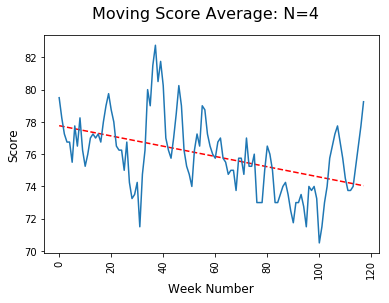

In [190]:
plt.figure(1)
plt.xticks(rotation=90)
linear_scale = [i for i in range(0, len(df))]
x_scale = linear_scale
z = np.polyfit(x_scale, df['SA'], 1)
p = np.poly1d(z)
plt.plot(x_scale, p(x_scale),"r--")
plt.plot(x_scale, df['SA'])
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.suptitle('Moving Score Average: N=4', fontsize=16)
# plt.plot(x_scale, df['PA'])